In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.stats import norm
from scipy.stats import truncnorm
import time
from joblib import Parallel, delayed
import multiprocessing
from IPython.display import clear_output
%matplotlib inline

In [8]:
## function to solve the combined system on a time grid t
## for a given initial condition and parameter value

def sens_solve(t,w,init):
    """
    This function produces the state and sensitivity solution on a time grid t
    
    Arguments
    =========
    t: (array) time grid on which we want the solution
    w: (array) array containing parameter values
    init: (array) array containing initial conditions for a,b (note a,b>0 for all time)
    """
    
    # ensure parameters are >0 and initial conditions are >0
    if (init[0] <= 0 or init[1] <= 0):
        print('Please ensure initial conditions are positive')
        return ValueError
    
    # add extra zeros to init for initial conditions on sensitivites
    init = np.append(init,np.repeat(0,8))
    
    # set up function for ODE as a system of coupled first order ODEs
    def f(y, t, params):
        a, b, g11, g12, g13, g14, g21, g22, g23, g24 = y   # unpack current values of y
        w1, w2, w3, w4 = params   # unpack parameter values
        derivs = [np.exp(w1)*(a**2)*b + np.exp(w2) - np.exp(w3)*a,
                 -np.exp(w1)*(a**2)*b + np.exp(w4),
                 np.exp(w1)*(a**2)*b + g11*(2*np.exp(w1)*a*b - np.exp(w3)) + np.exp(w1)*(a**2)*g21,
                 np.exp(w2) + g12*(2*np.exp(w1)*a*b - np.exp(w3)) + np.exp(w1)*(a**2)*g22,
                 -a*np.exp(w3) + g13*(2*np.exp(w1)*a*b - np.exp(w3)) + np.exp(w1)*(a**2)*g23,
                 g14*(2*np.exp(w1)*a*b - np.exp(w3)) + np.exp(w1)*(a**2)*g24,
                 -np.exp(w1)*(a**2)*b-2*np.exp(w1)*g11*a*b-np.exp(w1)*(a**2)*g21,
                 -2*np.exp(w1)*g12*a*b-np.exp(w1)*(a**2)*g22,
                 -2*np.exp(w1)*g13*a*b-np.exp(w1)*(a**2)*g23,
                 np.exp(w4)-2*np.exp(w1)*g14*a*b-np.exp(w1)*(a**2)*g24]
        return derivs
    
    # solve system of ODEs using odeint
    soln = odeint(f,init,t,args=(w,))
    
    # return solution
    return soln

In [9]:
## code to generate random initial conditions and solve system on a time grid t
def noisySchnaken(N,sigma_a,sigma_b,t,w,lower=0,upper=np.inf,mu_a=1,mu_b=1):
    """
    This function generates N sets of initial conditions and uses sens_solve code above to solve the system for these initial conditions.
    The initial conditions for a and b are drawn i.i.d from truncated normal distribution
    
    Arguments
    =========
    N: (int) number of random initial conditions to draw
    sigma_a: (float) standard deviation for truncated normal distribution for a
    sigma_b: (float) standard deviation for truncated normal distribution for b
    t: (array) time grid at which we want solution
    w: (array) array containing parameter values
    lower: (float) left truncation point for both a,b distn (set to 0 by default)
    upper: (float) right truncation point for both a,b distn (set to Inf by default)
    mu_a: (float) mean for truncated normal distribution for a (set to 1 by default)
    mu_b: (float) mean for truncated normal distribution for b (set to 1 by default)
    """
    
    # set up initial conditions
    init = np.zeros(N*2).reshape(N,-1)
    init[:,0] = truncnorm.rvs((lower-mu_a)/sigma_a,(upper-mu_a)/sigma_a,loc=mu_a,scale=sigma_a,size=N)  # initial condition for a
    init[:,1] = truncnorm.rvs((lower-mu_b)/sigma_b,(upper-mu_b)/sigma_b,loc=mu_b,scale=sigma_b,size=N)  # initial condition for b
    
    def solveSys(i):
        return sens_solve(t,w,init[i,:])
    
    num_cores = multiprocessing.cpu_count()
    
    results = Parallel(n_jobs=num_cores)(delayed(solveSys)(i) for i in range(N))
    
    # return results
    return results

In [10]:
## function to compute kernel at all possible pairs of points and store as a matrix.
## This function works for symmetric, translation invariant kernels 
## k(x,y)=psi(x-y), where psi is an even function (so k(x,y)=k(y,x))

def kernMatrix(p,q,psi):
    """
    This function evaluates the kernel at every possible combination between two different samples {p_i}, {q_j} 
    and stores result in a matrix K={K_ij} where K_ij = k(p_i,q_j)
    
    Arguments
    =========
    p, q: (arrays) iid sampled paths from the two distributions in question
     
    psi: (function) function computing the kernel k(x,y)=psi(x-y) where
       psi is an even function
    """
    
    # compute number of sampled paths for both distributions
    m = p.shape[0]
    n = q.shape[0]
    
    # compute the distance matrix D
    # (i.e. D is matrix containing all distances 
    # between all pairs of points in the samples
    # i.e. D_ij=||p_i-p_j||)
    D = cdist(p,q)
    
    # evaluate the kernel function for all possible pairs
    K = psi(D)
    
    # return K
    return K

In [11]:
## function to compute unbiased estimate of MMD 
## for sampled paths from above system. This
## function works for translation invariant kernels
## k(x,y)=psi(x-y), where psi is an even function
def MMD_U(p,q,psi):
    """
    Evaluates an unbiased estimate of MMD
     
    Arguments
    ==========
    p, q: iid sampled paths from the two distributions in question
     
    psi: function computing the kernel k(x,y)=psi(x-y) where
       psi is an even function
     
    """
    # compute number of sampled paths for both distributions
    m = p.shape[0]
    n = q.shape[0]
    
    # compute all the distance matrices D_pp, D_qq, D_pq
    # (i.e. D_pp is matrix containing all distances between 
    # ll pairs of points in the samples from p, and D_pq contains
    # the distances between all pairs with one point from samples of p
    # and other from samples of q)
    D_pp = cdist(p,p)
    D_qq = cdist(q,q)
    D_pq = cdist(p,q)
    
    # evaluate the kernel function for all possible pairs (pp,qq,pq)
    K_pp = psi(D_pp)
    K_qq = psi(D_qq)
    K_pq = psi(D_pq)
    
    # compute estimate and return
    est = (1/(m*(m-1)))*(K_pp.sum()-K_pp.trace())+(1/(n*(n-1)))*(K_qq.sum()-K_qq.trace())-(2/(m*n))*(K_pq.sum())
    return est

In [12]:
## for live updates in results
def live_plot(data,mmd,figsize=(12,7)):
    clear_output(wait=True)
    fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=figsize,constrained_layout=True)
    
    ax1.plot(data[:,0])
    ax1.grid()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel(r'$\theta_1$')
    
    ax2.plot(data[:,1])
    ax2.grid()
    ax2.set_xlabel('iteration')
    ax2.set_ylabel(r'$\theta_2$')
    
    ax3.plot(data[:,2])
    ax3.grid()
    ax3.set_xlabel('iteration')
    ax3.set_ylabel(r'$\theta_3$')
    
    ax4.plot(data[:,3])
    ax4.grid()
    ax4.set_xlabel('iteration')
    ax4.set_ylabel(r'$\theta_4$')
    
    ax5.plot(mmd)
    ax5.grid()
    ax5.set_xlabel('iteration')
    ax5.set_ylabel('MMD')
    
    fig.delaxes(ax6)
    
    plt.show()

In [13]:
## function to perform gradient descent (using Gaussian kernel k(x,y)=exp(-sigma||x-y||^2))
def MMD_grad_descent(y,t,sigma_a,sigma_b,sigma,w_init,n_sim,step_size=0.01,N_iter=100,tol=0.0001,lower=0,upper=np.inf,mu_a=1,mu_b=1):
    """
    Arguments
    =========
    y: (array) array holding the observed data (each row one sample)
    t: (array) array holding time points the data is observed at
    sigma_a: (float) standard deviation for truncated normal distribution for a
    sigma_b: (float) standard deviation for truncated normal distribution for b
    sigma: (float) bandwidth of Gaussian kernel
    w_init: (array) parameter values to initialise gradient descent with
    n_sim: (int) number of samples to simulate at each step of gradient descent
    step_size: (float) step size for gradient descent (set to 0.05 by default)
    tol: (float) tolerance level at which we stop the algorithm (if next w value is within this tolerance of previous value
                 ,using Euclidean norm, we stop the algorithm and return w) (set to 0.01 by default)
    lower: (float) left truncation point for both a,b distn (set to 0 by default)
    upper: (float) right truncation point for both a,b distn (set to Inf by default)
    mu_a: (float) mean for truncated normal distribution for a (set to 1 by default)
    mu_b: (float) mean for truncated normal distribution for b (set to 1 by default)
    """
    
    # pdb.set_trace()
    
    # set up Gaussian kernel function
    psi = lambda x: np.exp(-sigma*(x**2))
    
    # compute the number of observations in y
    m = y.shape[0]
    
    # set up array to hold w values
    w_hat = np.zeros((N_iter+1)*4).reshape(N_iter+1,-1)
    
    # put first w value in
    w_hat[0,:] = w_init
    
    # set up array to hold value of unbiased est of MMD
    MMD_est = np.zeros(N_iter+1)
    
    # perform the gradient descent
    for j in range(N_iter):
        # simulate a data set using previous parameter value
        dat = noisySchnaken(n_sim,sigma_a,sigma_b,t,w_hat[j,:],lower=0,upper=np.inf,mu_a,mu_b)
        dat = np.stack(dat)
        
        # store (a(0),a(t_1),...,a(t_{N-1}),b(0),b(t_1),...,b(t_{N-1})) values in a
        # n_sim x (2len(t)) array
        x = dat[:,:,0]
        x = np.concatenate((x,dat[:,:,1]),axis=1)  # concatenate b-values to the right of the a-values
        
        # compute unbiased est of MMD for monitoring performance
        MMD_est[j] = MMD_U(y,x,psi)
        
#         # save results every 1000 iterations
#         if (j != 0 and j % 1000 == 0):
#             np.save('w_hat_%s.npy'%(j),w_hat[0:(j+1),:])
#             np.save('MMD_est_%s'%(j),MMD_est[0:(j+1)])
        
        # store g_i matrices in a (n_sim x (2*len(t)) x 4) array g
        g = dat[:,:,2:6]
        g = np.concatenate((g,dat[:,:,6:10]),axis=1)
        
        # evaluate the kernel on all pairs using kernMatrix code above
        
        # within simulated data
        K_xx = kernMatrix(x,x,psi)
        
        # between observed and simulated
        K_xy = kernMatrix(x,y,psi)
        
        # compute x_i-x_j array (the (i,j,:) element is the vector x_i-x_j)
        diff_xx = x[:,None]-x[None,:]
        
        # compute x_i-y_j array
        diff_xy = x[:,None]-y[None,:]
        
        ## compute first term in update J
        
        # first form k(x_i,x_j)(x_i-x_j) array
        M_xx = np.einsum('ij,ijk->ijk',K_xx,diff_xx)
        
        # now form products (g_i^T)(k(x_i,x_j)(x_i-x_j))
        v_xx = np.einsum('iml,ijm->ijl',g,M_xx)
        
        # sum over all pairs (x_i,x_j) (note: diag terms are not meant to be present
        # but as they give 0 vector it is okay to sum over them)
        J_xx = np.einsum('ijm->m',v_xx)
        
        # times this by -4sigma/(n_sim(n_sim-1))
        J_xx = (-4*sigma/(n_sim*(n_sim-1)))*J_xx
        
        ## compute second term in update J
        
        # first form k(x_i,y_j)(x_i-y_j) array
        M_xy = np.einsum('ij,ijk->ijk',K_xy,diff_xy)
        
        # now form products ((g_i)^T)(k(x_i,y_j)(x_i-y_j))
        v_xy = np.einsum('iml,ijm->ijl',g,M_xy)
        
        # sum over all pairs (x_i,y_j)
        J_xy = np.einsum('ijm->m',v_xy)
        
        # times this by 4sigma/(m*n_sim)
        J_xy = (4*sigma/(m*n_sim))*J_xy
        
        # form J by adding the terms J_xx, J_xy
        J = J_xx + J_xy
        
        # perform the update
        w_new = w_hat[j,:] - step_size*J
        
        # accept and continue if w_new is at least tol away from previous value or
        # otherwise terminate algorithm
        if (np.linalg.norm(w_new-w_hat[j,:])>=tol):
            w_hat[j+1,:] = w_new
            #####################################################
            live_plot(np.exp(w_hat[0:(j+2),:]),MMD_est[0:(j+1)])
            #####################################################
        else:
            w_hat[j+1,:] = w_new
            
            # compute unbiased est of MMD for this new w val
            dat = noisySchnaken(n_sim,sigma_a,sigma_b,t,w_new,lower=0,upper=np.inf,mu_a=1,mu_b=1)
            dat = np.stack(dat)
            x = dat[:,:,0]
            x = np.concatenate((x,dat[:,:,1]),axis=1)
            
            # compute unbiased est of MMD for monitoring performance
            MMD_est[j+1] = MMD_U(y,x,psi)
            
            #######################################################
            live_plot(np.exp(w_hat[0:(j+2),:]),MMD_est[0:(j+2)])
            #######################################################
            
            # get rid of final columns/entries
            w_hat = w_hat[0:(j+2),:]#
            MMD_est = MMD_est[0:(j+2)]
            return w_hat, MMD_est
    
    # compute unbiased est of MMD for this final w val
    dat = noisySchnaken(n_sim,sigma_a,sigma_b,t,w_hat[-1,:],lower=0,upper=np.inf,mu_a=1,mu_b=1)
    dat = np.stack(dat)
    x = dat[:,:,0]
    x = np.concatenate((x,dat[:,:,1]),axis=1)
    MMD_est[-1] = MMD_U(y,x,psi)
    
    #######################################################
    live_plot(np.exp(w_hat[0:(j+2),:]),MMD_est[0:(j+2)])
    #######################################################
    
    # return w_hat, MMD_est
    return w_hat, MMD_est

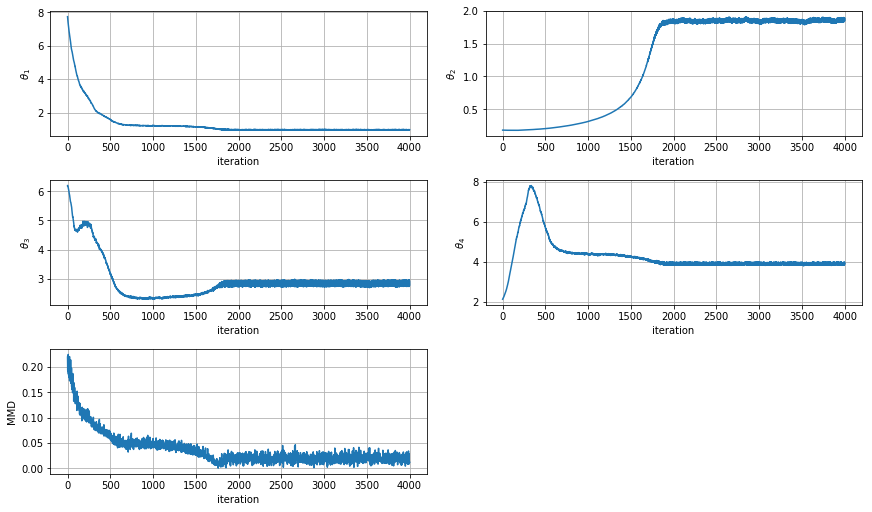

Time taken was: 3672.2988262176514
Bandwidth is: 1.7229612083702026
Initial parameter values are: [7.733 0.182 6.189 2.121]
Step size used is: 0.1
Max number of iterations is: 4000
Number of iterations actually performed was: 4000
Tolerence is: 0
Min MMD obtained is: 0.0
Parameter vector which obtained this minimum is: [1.037 1.524 2.763 4.01 ]
True parameter vector is: [1 2 3 4]
Euclidean distance from true parameter vector is: 0.533


In [15]:
# Trial one
# generate a data set
start = time.time()
N = 1000
sigma_a = 0.5
sigma_b = 0.5
t = np.linspace(0,1,10)
theta = np.array([1,2,3,4])
w = np.log(theta)

# set seed
np.random.seed(seed=48514)

dat = noisySchnaken(N,sigma_a,sigma_b,t,w)
dat = np.stack(dat)
y = dat[:,:,0]
y = np.concatenate((y,dat[:,:,1]),axis=1)

# compute bandwidth to use
distMat = cdist(y,y)
distMat = 0.5*(distMat**2)
sigma = np.sqrt(np.median(distMat))

# perform gradient descent
w_init = np.array([2.0455244196260973,-1.701156068460953,1.8227543098766503,0.7518004076513923])

n_sim = 100
step = 0.1
n_iter = 4000
tols = 0

np.random.seed(seed=28)
w_hat, MMD_est = MMD_grad_descent(y,t,sigma_a,sigma_b,sigma,w_init,n_sim,step_size=step,N_iter=n_iter,tol=tols)
end = time.time()

print('Time taken was: %s'%(end-start))
print('Bandwidth is: %s' %(sigma))
print('Initial parameter values are: %s' %(np.around(np.exp(w_init),decimals=3)))
print('Step size used is: %s' %(step))
print('Max number of iterations is: %s' %(n_iter))
print('Number of iterations actually performed was: %s' %(len(MMD_est)-1))
print('Tolerence is: %s' %(tols))

print('Min MMD obtained is: %s'%(np.around(MMD_est.min(),decimals=3)))
print('Parameter vector which obtained this minimum is: %s'%(np.around(np.exp(w_hat[MMD_est.argmin(),:]),decimals=3)))
print('True parameter vector is: %s' %(theta))
print('Euclidean distance from true parameter vector is: %s' %(np.around(np.linalg.norm(np.exp(w_hat[MMD_est.argmin(),:])-theta),decimals=3)))

In [16]:
## code for saving arrays produced
# np.save('w_hat.npy',w_hat)
# np.save('MMD_est.npy',MMD_est)

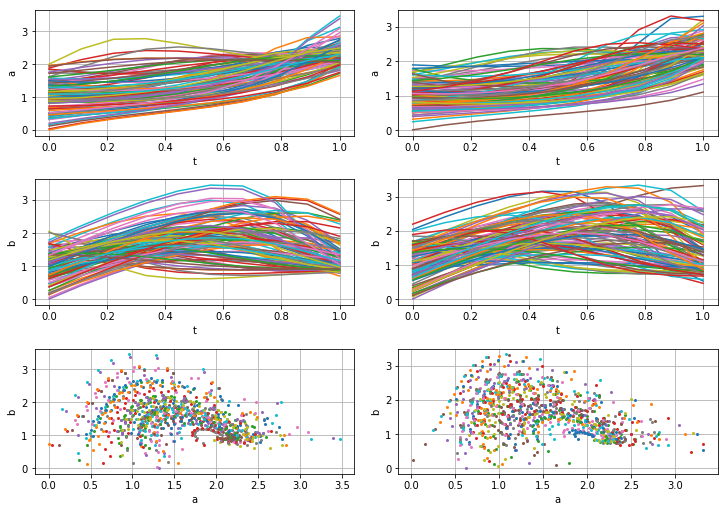

In [21]:
# code for plotting samples from true vector and from vector obtained from algorithm
w_true = np.log(theta)
sigma_a = 0.5
sigma_b = 0.5
t = np.linspace(0,1,10)

# plot solutions with these parameter vals
N_sols = 100
w_res = w_hat[MMD_est.argmin(),:]
np.random.seed(seed=8748641)
soln_res = noisySchnaken(N_sols,sigma_a,sigma_b,t,w_res)
soln_res = np.stack(soln_res)
soln_true = noisySchnaken(N_sols,sigma_a,sigma_b,t,w_true)
soln_true = np.stack(soln_true)

fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(10,7),constrained_layout=True)
for i in range(N_sols):
    ax1.plot(t,soln_true[i,:,0])
    ax2.plot(t,soln_res[i,:,0])
    ax3.plot(t,soln_true[i,:,1])
    ax4.plot(t,soln_res[i,:,1])
    ax5.plot(soln_true[i,:,0],soln_true[i,:,1],'o',ms=2)
    ax6.plot(soln_res[i,:,0],soln_res[i,:,1],'o',ms=2)
ax1.set_xlabel('t')
ax2.set_xlabel('t')
ax3.set_xlabel('t')
ax4.set_xlabel('t')
ax1.set_ylabel('a')
ax2.set_ylabel('a')
ax3.set_ylabel('b')
ax4.set_ylabel('b')
ax5.set_xlabel('a')
ax6.set_xlabel('a')
ax5.set_ylabel('b')
ax6.set_ylabel('b')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
plt.show() 

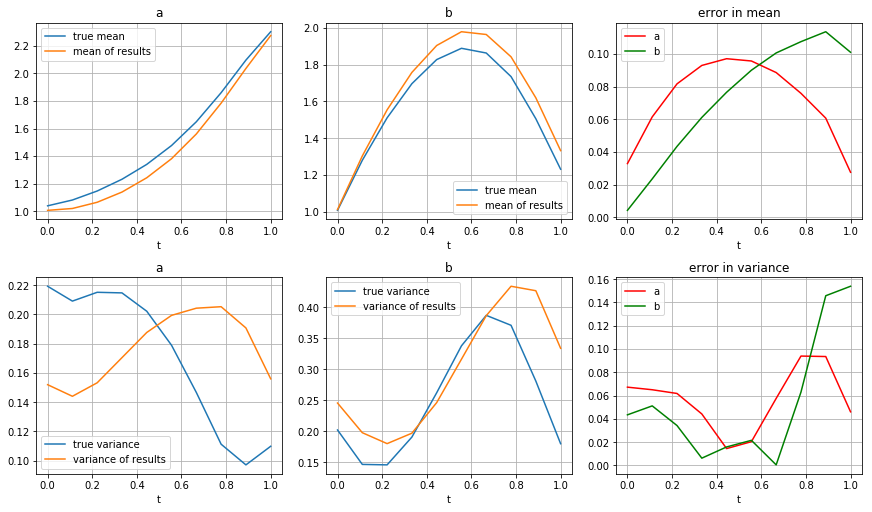

In [22]:
# see how similar results are
a_mean_true = soln_true[:,:,0].mean(axis=0)
b_mean_true = soln_true[:,:,1].mean(axis=0)
a_mean_res = soln_res[:,:,0].mean(axis=0)
b_mean_res = soln_res[:,:,1].mean(axis=0)

a_var_true = soln_true[:,:,0].var(axis=0)
b_var_true = soln_true[:,:,1].var(axis=0)
a_var_res = soln_res[:,:,0].var(axis=0)
b_var_res = soln_res[:,:,1].var(axis=0)

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize = (12,7),constrained_layout=True)

ax1.plot(t,a_mean_true,label='true mean')
ax1.plot(t,a_mean_res,label='mean of results')
ax1.set_xlabel('t')
ax1.set_title('a')
ax1.legend()
ax1.grid()

ax2.plot(t,b_mean_true,label='true mean')
ax2.plot(t,b_mean_res,label='mean of results')
ax2.set_xlabel('t')
ax2.set_title('b')
ax2.legend()
ax2.grid()

ax3.plot(t,np.abs(a_mean_true-a_mean_res),'r',label='a')
ax3.plot(t,np.abs(b_mean_true-b_mean_res),'g',label='b')
ax3.set_xlabel('t')
ax3.set_title('error in mean')
ax3.legend()
ax3.grid()

ax4.plot(t,a_var_true,label='true variance')
ax4.plot(t,a_var_res,label='variance of results')
ax4.set_xlabel('t')
ax4.set_title('a')
ax4.legend()
ax4.grid()

ax5.plot(t,b_var_true,label='true variance')
ax5.plot(t,b_var_res,label='variance of results')
ax5.set_xlabel('t')
ax5.set_title('b')
ax5.legend()
ax5.grid()

ax6.plot(t,np.abs(a_var_true-a_var_res),'r',label='a')
ax6.plot(t,np.abs(b_var_true-b_var_res),'g',label='b')
ax6.set_xlabel('t')
ax6.set_title('error in variance')
ax6.legend()
ax6.grid()